In [ ]:
# Import required libraries to run the naive baseline
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
from collections import OrderedDict
import matplotlib.pyplot as plt
import pickle

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.models import mobilenet_v3_small

In [ ]:
#############################################
# FUNCTIONS
#############################################

def show_images(df, image_dir, n_images=5, title='None'):
    N = len(df)
    plt.figure(figsize=(15, (N//5 + 1)*3))
    for i in range(N):
        plt.subplot(N//5 + 1, n_images, i + 1)
        img = Image.open(f"{image_dir}/{df.iloc[i]['filename']}")
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

In [ ]:
df_train = pd.read_csv("data/listes_training/data_100K/train_100K.csv", delimiter=' ')
df_test = pd.read_csv("data/listes_training/data_100K/test_students.csv", delimiter=' ')

image_dir = "data/crops_100K"

df_train.head(-10)

# Questions

1. Quelles questions essayons de résoudre (ou de réfuter) ?

- Distribution des occlusions de visage : Quelle est la distribution générale des pourcentages d'occlusion de visage dans notre jeu de données ?
- Mais pourquoi il y a des valeurs entre 0 et 1 pour la variable gender? 
- Impact du genre : La distribution de l'occlusion du visage diffère-t-elle entre les hommes et les femmes ?
- Extrêmes des occlusions : Quelles sont les caractéristiques des images avec des pourcentages d'occlusion très élevés ou très faibles ?

2. Quel type de données avez-vous et comment traitez-vous les différents types ?

FaceOcclusion : Variable continue représentant le pourcentage d'occlusion du visage.
Gender : Variable binaire indiquant le genre (0 pour femme, 1 pour homme). 

3. Qu'est-ce qui manque dans les données et comment y remédiez-vous ?

- valeurs manquantes : Vérifier la présence de valeurs manquantes dans FaceOcclusion et gender.
- Traitement : Imputation ou suppression des lignes avec des valeurs manquantes.
- Diversité des images : Vérifier si la diversité des images (conditions d'éclairage, angles de prise de vue, types d'occlusion) est suffisante.
- Traitement : Utilisation de techniques d'augmentation de données pour améliorer la diversité.

4. Où sont les outliers et pourquoi devrions-nous en soucier ?
- Détection des outliers : Identifier les valeurs extrêmes de FaceOcclusion qui pourraient influencer négativement l'analyse.
- Traitement : Analyse des caractéristiques des outliers pour comprendre leur impact potentiel.
- Impact des outliers : Les outliers peuvent affecter les statistiques descriptives et les performances du modèle.
- Traitement : Décider de les traiter séparément ou de les supprimer.

5. Comment pouvez-vous ajouter, modifier ou supprimer des caractéristiques pour tirer le meilleur parti de vos données ?

# Analyse du target

In [ ]:
# Statistiques de base pour la colonne FaceOcclusion
print(df_train['FaceOcclusion'].describe())

# Distribution des genres
print(df_train['gender'].value_counts())

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution de FaceOcclusion
plt.figure(figsize=(10, 6))
sns.histplot(df_train['FaceOcclusion'], bins=50, kde=True)
plt.title('Distribution de FaceOcclusion')
plt.xlabel('FaceOcclusion')
plt.ylabel('Fréquence')
plt.show()

In [ ]:
# Calcul du pourcentage d'observations avec FaceOcclusion > 0.4
percentage_above = (df_train['FaceOcclusion'] > 0.4).mean() * 100
print(f"{percentage_above:.2f}% des observations ont une valeur de FaceOcclusion supérieure à 0.4.")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Box plot de FaceOcclusion
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_train['FaceOcclusion'])
plt.title('Box Plot de FaceOcclusion')
plt.xlabel('FaceOcclusion')
plt.show()



La distribution de FaceOcclusion montre que la majorité des images ont une faible occlusion du visage, avec un nombre décroissant d'images à mesure que le pourcentage d'occlusion augmente. 

Cette décroissance est très forte au départ avant de devenir de plus en plus moindre après.

Lorsque le taux d'occlusion s'étend au dessus de 0.4, on voit qu'il y a des outliers. 

- Si l'algorithme exige la normalité, il faut transformer cette variable.

- Il faut détecter la cause de l'occlusion à chaque bins. Pour les 04 premières bins, ils pourront avoir des spécificités. Sur la suite jusqu'à 0.4, il est fort probable d'avoir des bins ayant les mêmes caractères. Il faut les combiner. Pour le reste, on devrait les analyser particulièrement.  

In [ ]:
show_images(df_train.sample(10), image_dir, title='Random images from the training set')

In [ ]:
# Définir les bins
bins_first = [0.00, 0.02, 0.04, 0.06]
bin_ranges_first = [(0, 0.02), (0.02, 0.04), (0.04, 0.06), (0.06, 0.08)]

# Afficher les images pour les bins spécifiques
for bin_range in bin_ranges_first:
    selection = df_train[(df_train['FaceOcclusion'] >= bin_range[0]) & (df_train['FaceOcclusion'] < bin_range[1])]
    title_bin = f"FaceOcclusion entre {bin_range[0]} et {bin_range[1]}\n {len(selection)} images"
    show_images(selection.head(20), image_dir, n_images=6, title=title_bin)


**Conclusion pour le Bin "FaceOcclusion entre 0 et 0.02"**

Les images de ce bin montrent que la plupart des visages sont presque complètement visibles, avec de très légères obstructions dues à :

Éclairage et ombres : Variations légères d'éclairage créant des ombres minimes.
Accessoires légers : Lunettes discrètes ou petits accessoires.
Cheveux : Cheveux couvrant légèrement le visage.
Expressions faciales : Expressions influençant légèrement la visibilité des parties du visage


**Conclusion pour le Bin "FaceOcclusion entre 0.02 et 0.04"
Les images de ce bin montrent des obstructions légères dues à :

Lunettes : Accessoires couvrant une petite partie des yeux.
Ombres : Variations d'éclairage créant des ombres.
Cheveux : Cheveux couvrant légèrement le visage.
Expressions faciales : Expressions influençant légèrement la visibilité de certaines parties du visage

Les obstructions sont généralement mineures mais légèrement plus prononcées que celles du bin précédent (0 à 0.02).



**Conclusion pour le Bin "FaceOcclusion entre 0.04 et 0.06"**
Les images de ce bin montrent des obstructions modérées dues à :

Accessoires : Lunettes couvrant une partie des yeux.
Cheveux : Cheveux couvrant une partie importante du visage.
Ombres : Variations d'éclairage créant des ombres.
Expressions faciales : Expressions influençant la visibilité des parties du visage.
Les obstructions dans ce bin sont plus prononcées que dans les bins précédents, mais restent modérées.


**Passons maintenant à l'analyse du bin suivant : "FaceOcclusion entre 0.06 et 0.08".**
En analysant les images dans chaque bin, nous avons identifié plusieurs causes d'occlusion :

Lunettes de soleil ou optiques : Couvre une partie des yeux.
Cheveux : Couvre légèrement à modérément le visage.
Ombres : Variations d'éclairage créant des ombres sur le visage.
Expressions faciales : Influencent la visibilité des parties du visage

In [ ]:
# Définir les bins et les plages
bins_combined = [(0.08, 0.1), (0.1, 0.2), (0.2, 0.3), (0.3, 0.4)]
image_dir = "data/crops_100K"

# Afficher les images pour les bins combinés
for bin_range in bins_combined:
    selection = df_train[(df_train['FaceOcclusion'] >= bin_range[0]) & (df_train['FaceOcclusion'] < bin_range[1])]
    title_bin = f"FaceOcclusion entre {bin_range[0]} et {bin_range[1]}\n {len(selection)} images"
    show_images(selection.head(10), image_dir, n_images=10, title=title_bin)

Lunettes de soleil ou optiques : Couvre une partie des yeux.
Cheveux : Couvre légèrement à modérément le visage.
Ombres : Variations d'éclairage créant des ombres sur le visage.
Expressions faciales : Influencent la visibilité des parties du visage
Objets : mirco, main, bonet

In [ ]:
# Définir les bins et les plages
bins_high = [(0.4, 0.5), (0.5, 0.6), (0.6, 0.7), (0.7, 0.8), (0.8, 0.9), (0.9, 1.0)]
image_dir = "data/crops_100K"

# Afficher les images pour les bins au-delà de 0.4
for bin_range in bins_high:
    selection = df_train[(df_train['FaceOcclusion'] >= bin_range[0]) & (df_train['FaceOcclusion'] <= bin_range[1])]
    title_bin = f"FaceOcclusion entre {bin_range[0]} et {bin_range[1]}\n {len(selection)} images"
    show_images(selection.head(5), image_dir, n_images=5, title=title_bin)

Cheveux : Couvre légèrement à presque entièrement le visage.
Lunettes de soleil ou optiques : Couvre une grande partie des yeux.
Objets : Pommes, chapeaux, microphones, et autres objets couvrant le visage.
Maquillage ou peinture : Couvre une grande partie du visage.
Ombres et effets de lumière : Variations d'éclairage créant des ombres.
Qualité d'image basse : Artefacts de compression couvrant le visage.

In [ ]:
# Données manquantes


# Analyse de gender

In [ ]:
# Distribution de gender
plt.figure(figsize=(10, 6))
sns.histplot(df_train['gender'], bins=50, kde=True)
plt.title('Distribution de la variable gender')
plt.xlabel('Gender')
plt.ylabel('Fréquence')
plt.show()


In [ ]:
# Valeurs uniques de gender
unique_genders = df_train['gender'].unique()
print(f"Valeurs uniques de gender : {unique_genders}")

In [ ]:
# Plot histogram of gender between 0.1 and 0.9 with 40 baskets
gender_mixed = df_train[(df_train['gender'] > 0.1) & (df_train['gender'] < 0.9)]
plt.hist(gender_mixed['gender'], bins=40)
plt.title('Zoom on gender values between 0.1 and 0.9 (40 bins)\n'+str(gender_mixed.shape[0])+' images in total')
plt.show()
df_gender_4_6 = df_train[(df_train['gender'] > 0.4) & (df_train['gender'] < 0.6)]
print(len(df_gender_4_6))

çà c'est la probabilité d'être homme ou femme
çelà veut dire qu'il y a plus de probabilité qu'un individu soit homme dans notre base de données. En tout cas, il y a plus d'hommes que des femmes. 

# Relation entre Target et gender

In [ ]:
# Utiliser les noms corrects des colonnes (assumons que les colonnes s'appellent 'FaceOcclusion' et 'gender')
cross_table = pd.crosstab(df_train['FaceOcclusion'], df_train['gender'])

# Afficher le tableau croisé
print(cross_table)

# Calculer le nombre total d'individus par FaceOcclusion
total_by_faceocclusion = cross_table.sum(axis=1)

# Diviser chaque valeur dans le tableau croisé par le nombre total d'individus par FaceOcclusion
cross_table_percent = cross_table.div(total_by_faceocclusion, axis=0) * 100

# Création d'un graphique à barres empilées
cross_table_percent.plot(kind='bar', stacked=True, color=['lightgreen', 'black', 'red'])
plt.title('Répartition des genres par FaceOcclusion (en pourcentage)')
plt.xlabel('FaceOcclusion')
plt.ylabel('Pourcentage')
plt.xticks(rotation=0)
plt.legend(title='Gender')
plt.show()


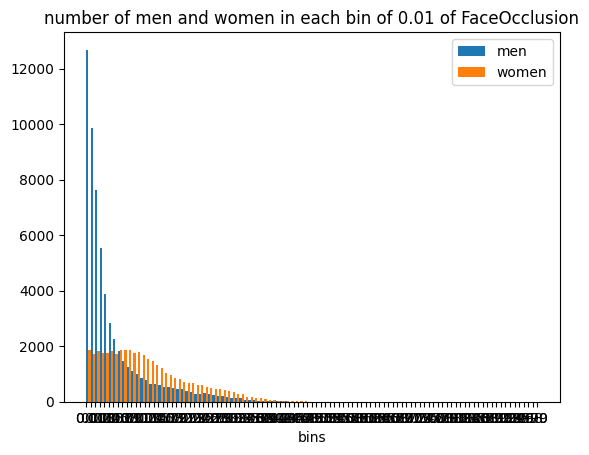

In [ ]:
bins = np.arange(0, 1.01, 0.01)
df_train['FaceOcclusionBin'] = pd.cut(df_train['FaceOcclusion'], bins=bins, include_lowest=True)

cross_table = pd.crosstab(df_train['FaceOcclusionBin'], df_train['gender'], normalize='index') * 100
cross_table.plot(kind='bar', stacked=True, color=['orange', 'blue'])
plt.title('Répartition des genres par FaceOcclusion (en pourcentage)')
plt.xlabel('FaceOcclusion')
plt.ylabel('Pourcentage')
plt.xticks(rotation=90)
plt.legend(title='Genre', labels=['Femme', 'Homme'])
plt.show()

In [ ]:
from scipy.stats import chi2_contingency

df_train['FaceOcclusionBin'] = pd.cut(df_train['FaceOcclusion'], bins=bins, include_lowest=True)
contingency_table = pd.crosstab(df_train['FaceOcclusionBin'], df_train['gender'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi2 Statistic: {chi2}, p-value: {p}")


In [ ]:
plt.figure(figsize=(12, 6))
cross_table.plot(kind='bar', stacked=True, color=['orange', 'blue'])
plt.title('Répartition des genres par FaceOcclusion (en pourcentage)', fontsize=16)
plt.xlabel('FaceOcclusion', fontsize=14)
plt.ylabel('Pourcentage', fontsize=14)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=12)
plt.legend(title='Genre', labels=['Femme', 'Homme'], fontsize=12)
plt.show()
